Amanda Curtis, May 2025

# Mini Project #2: Multi-controlled U Gate 

## Problem Statement


Write a Qiskit function that takes two inputs: a positive integer n and a matrix U $\in{U(2)}$. The function should and output a quantum circuit on $n+1$ qubits, possibly with further ancillas, that implements a multi-controlled U gate, $C^nU$. 

That is: 

$$C^nU|x\rangle_n{|y\rangle_1}=
\begin{equation}
f(x) = \begin{cases}
|x\rangle_nU|y\rangle_1 & \text{if } x = (1,1,...,1) \\
|x\rangle_n|y\rangle_1 & \text{otherwise } 
\end{cases}
\end{equation} $$

Note that we may only use arbitrary 1-qubit gates (U gates) and CX gates, and that no classical bit measurements will be allowed. 


In [13]:
# Checking that we have everything we need for qiskit 
%pip install qiskit pylatexenc


Note: you may need to restart the kernel to use updated packages.


In [14]:
# Importing necessary other packages and ___ from qiskit 

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

## Process Outline

1. We begin by discussing how to contstruct the multi-controlled U gate. This involves:

    A. Creating S, T, T(dag), and H gates from the allowable gates 

    B. Using these to create a function that builds a Toffoli gate with certain inputs 

    C. Finally, using 2(n-1) of these Toffoli gates in the final function that implements the multi-controlled gate

2. We will then work out qiskit code with benchmarking for low values of n. 

3. Fianlly, we provide an analysis of the various complexities and resources used (given out gate count, gate depth, and number of ancillas)

## 1. Creating the Circuit 
 The following construction is inspired by Figure 4.10 on pg 184 of Nielsen and Chuang

[Source](https://profmcruz.wordpress.com/wp-content/uploads/2017/08/quantum-computation-and-quantum-information-nielsen-chuang.pdf)

#### Permitted Gates

Recall, U gates are definied as follows: 

$U(\theta, \varphi, \lambda) = \begin{bmatrix} \cos \left( \tfrac{\theta}{2} \right) & - e^{i \lambda} \sin \left( \tfrac{\theta}{2} \right) \\ e^{i \varphi} \sin \left( \tfrac{\theta}{2} \right) & e^{i (\varphi + \lambda)} \cos \left( \tfrac{\theta}{2} \right) \end{bmatrix}$,

for some $(\theta, \varphi, \lambda) \in \left[ 0, 2 \pi \right)^3$. 

Every 1-qubit gate can be written in this form. 

-----------------------------------------------------

CX gates are 2-qubit gates, also known as "Controlled-NOT" gates, defined as:

$CX \ket{x}\ket{y} = \ket{x} \ket{x \oplus y} = \left\{ \begin{array}{ll} \ket{x} \ket{y}, & \textnormal{if } x = 0, \\ \ket{x} \ket{1 \oplus y}, & \textnormal{if } x = 1. \end{array} \right.$

Its matrix in the computational basis:

$[CX] = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$.

And we can view the action on our basis vectors as: 

$|00>\rightarrow{|00>}$

$|01>\rightarrow{|11>}$

$|10>\rightarrow{|10>}$

$|11>\rightarrow{|01>}$


We note that qiskit convention for ordering of bits differs from our in-class definition. In particular, qubit 0 is the right-most bit, so the expression $|10>$ indicates that qubit $q_0$ is $|0>$ and qubit $q_1$ is $|1>$. Thus, the action of a CX gate looks a little different here. 

Information summarized from IBM's [Utility Scale Quantum Computing, Lesson 2](https://learning.quantum.ibm.com/course/utility-scale-quantum-computing/lesson-02-bits-gates-and-circuits)

-------------------------------------------------------

### First, we must create the gates necessary to build a Toffoli gate from our permitted gates.

The construction in Nielsen and Chuang requires use of $2(n-1)$ Toffoli gates, which are not directly allowed by the project statement. Indeed, if we wish to use one, we must construct it from the allowed gates; U and CX. 

We work out the construction of this gate, which will require a mix of Hadamard, phase, and T ($\pi/8$) gates, as well as the $CX$ gate, of which we already have use.

Below is a breif justification for why each of the other three gates are allowable, constructing them out of the general U gate by scratch. When implementing later we opt to use the gates available with Qiskit (for ease of notation, mostly).


#### Hadamard Gate: 

Take $\theta=\pi/2$, $\varphi=0$, and $\lambda=\pi$ and get

$U(\theta,\varphi, \lambda)$ = $U(\pi/2, 0, \pi) = \begin{bmatrix} \cos \left( \tfrac{\pi}{4} \right) & - e^{i \pi} \sin \left( \tfrac{\pi}{4} \right) \\ e^{0} \sin \left( \tfrac{\pi}{4} \right) & e^{i (\pi)} \cos \left( \tfrac{\pi}{4} \right) \end{bmatrix}$,

Which simplifies to $H = \tfrac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & - 1 \end{bmatrix}$.

#### Phase Gate (S):

Take $\theta=0$, $\varphi=\pi/2$, and $\lambda=0$ and get


$U(\theta,\varphi, \lambda) =$ $S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}$ 

#### T ($\frac{\pi}{8}$) Gate (and $T^{\dagger}$):

In a choice similar to $S$, we obtain $T$ by taking 

$\theta=0$, $\varphi=\pi/4$, and $\lambda=0$ and then 


$U(\theta,\varphi, \lambda) =$ $T = \begin{bmatrix} 1 & 0 \\ 0 & e^{i{\pi/4}} \end{bmatrix}$ 

From this, we can also define $T^{\dagger}$ as $U(\theta,\varphi, \lambda)$ = $T = \begin{bmatrix} 1 & 0 \\ 0 & e^{i{-\pi/4}} \end{bmatrix}$, simply taking $\varphi = -\pi/4$ in our U gate construction.  

### Next, we write a function that builds a Toffoli Gate
This construction follows the methods described in Nielsen and Chuang (pg. 182, figure 4.9)

In [15]:
# We build a function that will implement a Toffoli Gate (using allowed gates) within our larger multicontrolled U gate
def Toff_Gate_Create(quantum_register, ancilla_register, control_qubit_1, control_qubit_2, target_qubit):

    

    # Naming the circuit and preparing the set up

    Toffoli_Gate = QuantumCircuit(quantum_register, ancilla_register, name="Toffoli")

    Toffoli_Gate.h(target_qubit)
    Toffoli_Gate.cx(control_qubit_2, target_qubit)
    Toffoli_Gate.tdg(target_qubit)
    Toffoli_Gate.cx(control_qubit_1,target_qubit)
    Toffoli_Gate.t(target_qubit)
    Toffoli_Gate.cx(control_qubit_2, target_qubit)
    Toffoli_Gate.tdg(target_qubit)
    Toffoli_Gate.cx(control_qubit_1,target_qubit)
    Toffoli_Gate.tdg(control_qubit_2)
    Toffoli_Gate.t(target_qubit)
    Toffoli_Gate.cx(control_qubit_1, control_qubit_2)
    Toffoli_Gate.h(target_qubit)
    Toffoli_Gate.tdg(control_qubit_2)
    Toffoli_Gate.cx(control_qubit_1, control_qubit_2)
    Toffoli_Gate.t(control_qubit_1)
    Toffoli_Gate.s(control_qubit_2)

    return Toffoli_Gate



I did some testing of various things to ensure I was creating what I wanted here - for now I will keep this work but I might delete it later. 

We verify that this is indeed a Toffoli gate by printing its matrix representation for the n=3 case. 

In [16]:
quantum_register_test = QuantumRegister(size = 3, name = 'x')
anc_reg_test = AncillaRegister(size = 2, name = 'a')

In [17]:
print(np.round(np.array(Operator(Toff_Gate_Create(quantum_register_test, anc_reg_test, quantum_register_test[0], quantum_register_test[1], quantum_register_test[2])))))

[[1.-0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.-0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.-0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.-0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.-0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


### Next, we build our multi-controlled U gate 



We present a function which will take in a gate U and a number $n\in{\mathbb{Z}_{\geq{1}}}$, and build a multicontrolled gate with this information. This function will use the Toffoli gate we build in the previous section. 

In [29]:
# I start with setting n=5, but this should work for any n>4
# U will need to be defined by its Theta, Phi, and Lambda. I picked some starting values that are simple but non-trivial. 


n = 5
Theta = 0
Phi =np.pi
Lambda = 0

In [27]:
# Defining the Multi-Controlled U gate Function 
def Multi_Controlled_U(n, Theta, Phi, Lambda):
    quantum_register = QuantumRegister(size=n+1, name="x") 
    ancilla_register = AncillaRegister(size=n-1, name="a") 
    #target_register = QuantumRegister(size=1, name = 't')
    Multi_Controlled_U = QuantumCircuit(quantum_register, ancilla_register, name='Multi_Controlled_U')

    Multi_Controlled_U.compose(Toff_Gate_Create(quantum_register, ancilla_register, quantum_register[0], quantum_register[1], ancilla_register[0]), inplace=True)
    Multi_Controlled_U.barrier()
    for i in range(n-2):
        Multi_Controlled_U.compose(Toff_Gate_Create(quantum_register, ancilla_register, quantum_register[i+2], ancilla_register[i], ancilla_register[i+1]), inplace=True)
        Multi_Controlled_U.barrier()

    Multi_Controlled_U.u(Theta, Phi, Lambda, quantum_register[n])
    Multi_Controlled_U.barrier()

    for i in range(n-2):
        Multi_Controlled_U.compose(Toff_Gate_Create(quantum_register, ancilla_register, quantum_register[n-i], ancilla_register[n-3-i], ancilla_register[n-2-i]), inplace=True)
        Multi_Controlled_U.barrier()
    Multi_Controlled_U.compose(Toff_Gate_Create(quantum_register, ancilla_register, quantum_register[0], quantum_register[1], ancilla_register[0]), inplace=True)

    return Multi_Controlled_U.draw(output="mpl", style="bw")



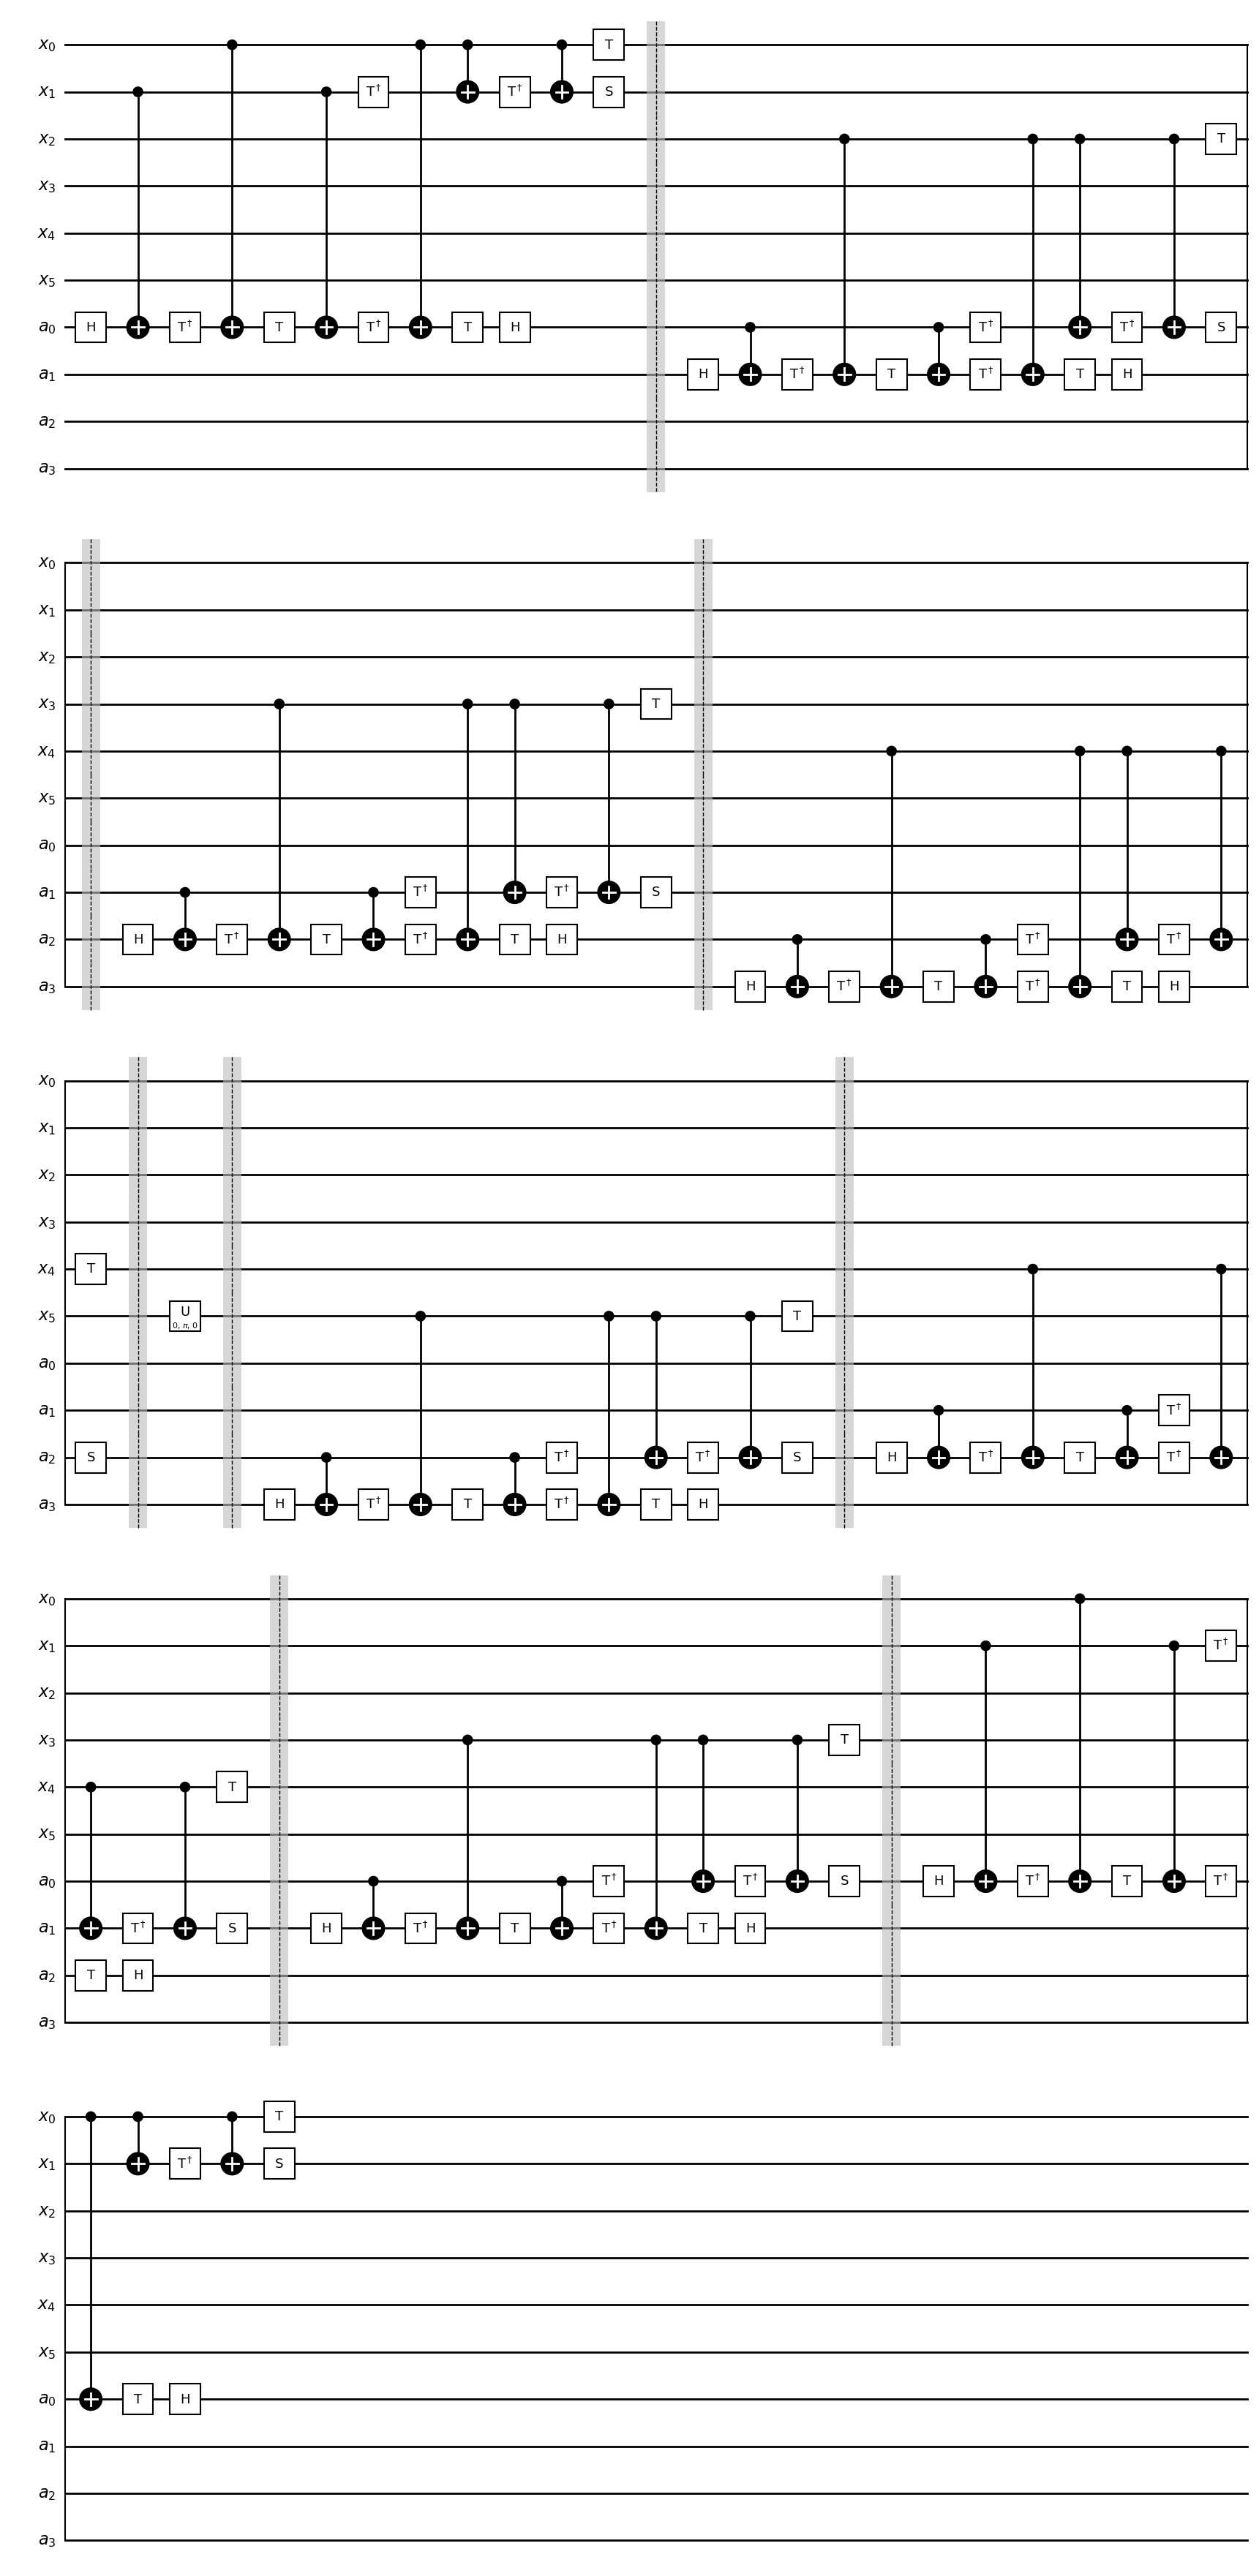

In [28]:
Multi_Controlled_U(n,Theta, Phi, Lambda)

Following the visual representation of this multi-controlled U gate, I should probably test it on some stuff  - Later

## 2. Benchmarking 

## 3. Analysis 

This construction of a multi-controlled U gate $C^nU$ requires $n+1$ 'working' qubits and $n-1$ ancilla qubits. While most constructions list the last working qubit after the ancilla, I choose to keep it in the original quantum register (Please let me know if this is not advised!). So we have $(n+1)+(n-1)=2n$ qubits being used in each circuit.

Each Toffoli/CCX gate that I implemented uses 16 gates, 6 of which are CX gates. As mentioned above, each $C^nU$ gate needs $2(n-1)$ Toffoli gates. There is also one instance of the $U$ gate in our $C^nU$, regardless of the value of $n$. Thus, in total, the circuit uses. 

$6*2(n-1)=12n-12$ CX Gates

and

$10*2(n-1)+1=20n-20+1=20n-19$ $U$ gates, 

for a total of $32n-31$ gates. 

At this point, I suspect using a standard qiskit ready CCX gate in place of my constructed CCX/Toffoli gate would technically be more efficient, and such a construction would only use $2n+1$ total gates. 


### Sources Used: 

["Quantum Computation and Quantum Information"](https://profmcruz.wordpress.com/wp-content/uploads/2017/08/quantum-computation-and-quantum-information-nielsen-chuang.pdf), accessed via link on Slack

Nielsen, Michael A, and Isaac L Chuang. Quantum Computation and Quantum Information. Cambridge Cambridge University Press, 2010.